In [1]:
import os
import sys
import numpy as np
import neuroglancer

In [2]:
HOME = os.path.expanduser("~")
PATH = os.path.join(HOME, 'programming/pipeline_utility')
sys.path.append(PATH)
from utilities.utilities_cvat_neuroglancer import get_structure_number, get_segment_properties, NumpyToNeuroglancer

In [3]:
ATLAS_PATH = '/net/birdstore/Active_Atlas_Data/data_root/atlas_data/atlasV7'
ORIGIN_PATH = os.path.join(ATLAS_PATH, 'origin')
VOLUME_PATH = os.path.join(ATLAS_PATH, 'structure')
origin_files = sorted(os.listdir(ORIGIN_PATH))
volume_files = sorted(os.listdir(VOLUME_PATH))

structure_volume_origin = {}
for volume_filename, origin_filename in zip(volume_files, origin_files):
    structure = os.path.splitext(volume_filename)[0]
    if structure not in origin_filename:
        print(structure, origin_filename)
        break

    color = get_structure_number(structure.replace('_L', '').replace('_R', ''))

    origin = np.loadtxt(os.path.join(ORIGIN_PATH, origin_filename))
    volume = np.load(os.path.join(VOLUME_PATH, volume_filename))
    
    volume = np.rot90(volume, axes=(0,1))
    volume = np.flip(volume, axis=0)
    volume[volume > 0.8] = color
    volume = volume.astype(np.uint8)
    
    structure_volume_origin[structure] = (volume, origin)
print(structure_volume_origin.keys())

dict_keys(['10N_L', '10N_R', '12N', '3N_L', '3N_R', '4N_L', '4N_R', '5N_L', '5N_R', '6N_L', '6N_R', '7N_L', '7N_R', '7n_L', '7n_R', 'AP', 'Amb_L', 'Amb_R', 'DC_L', 'DC_R', 'IC', 'LC_L', 'LC_R', 'LRt_L', 'LRt_R', 'PBG_L', 'PBG_R', 'Pn_L', 'Pn_R', 'RMC_L', 'RMC_R', 'RtTg', 'SC', 'SNC_L', 'SNC_R', 'SNR_L', 'SNR_R', 'Sp5C_L', 'Sp5C_R', 'Sp5I_L', 'Sp5I_R', 'Sp5O_L', 'Sp5O_R', 'Tz_L', 'Tz_R', 'VCA_L', 'VCA_R', 'VCP_L', 'VCP_R', 'VLL_L', 'VLL_R'])


In [4]:
x_length = 1000
y_length = 1000
z_length = 300
atlasV7_volume = np.zeros((x_length, y_length, z_length), dtype=np.uint32)

for structure, (volume, origin) in structure_volume_origin.items():
    x, y, z = origin
    x_start = int(x) + x_length // 2
    y_start = int(y) + y_length // 2
    z_start = int(z) // 2 + z_length // 2
    x_end = x_start + volume.shape[0]
    y_end = y_start + volume.shape[1]
    z_end = z_start + (volume.shape[2] + 1) // 2

    z_indices = [z for z in range(volume.shape[2]) if z % 2 == 0]
    volume = volume[:, :, z_indices]
    atlasV7_volume[x_start:x_end, y_start:y_end, z_start:z_end] += volume

In [12]:
atlasV7_volume.shape

(1000, 1000, 300)

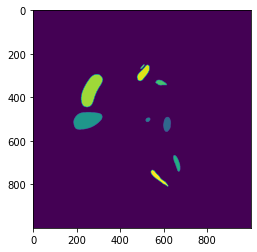

In [15]:
import matplotlib.pyplot as plt
plt.imshow(atlasV7_volume[:,:,100])

In [16]:
%%time
OUTPUT_DIR = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/structures/atlasV7'

ng = NumpyToNeuroglancer(animal = 'Atlas' , volume = atlasV7_volume, scales = [10000, 10000, 20000],layer_type = 'segmentation', data_type = atlasV7_volume.dtype)
ng.preview()


A new layer named segmentation_[10000, 10000, 20000] is added to:
http://127.0.0.1:38373/v/6e56bb84a0750b70e62f7e5ea31746324dc76fa6/
CPU times: user 796 µs, sys: 792 µs, total: 1.59 ms
Wall time: 1.32 ms


In [ ]:
ng.init_precomputed(OUTPUT_DIR)
ng.add_segment_properties(get_segment_properties())
ng.add_downsampled_volumes()
ng.add_segmentation_mesh()

In [6]:
with open('atlasV7.npy', 'wb') as file:
    np.save(file, atlasV7_volume)